In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import cv2
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
import datetime
# from google.colab import drive
import os
import zipfile
import random
import seaborn as sns
from pathlib import Path
from PIL import Image
# import cv2 as cv
from collections import Counter
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
import pathlib
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
path = "dataset_sm/"
classes = os.listdir(path)
print(f'Total number of categories: {len(classes)}')

Total number of categories: 72


In [3]:
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

Total number of images in dataset: 4605


In [4]:
X = []
Y = []

size = (224,224)

for index, label in enumerate(os.listdir(path)):
    # Łączenie ścieżki do podfoldera z głównym folderem
    subfolder_path = os.path.join(path, label)
    
    # Sprawdzenie, czy ścieżka wskazuje na folder
    if os.path.isdir(subfolder_path):
        # Przechodzenie przez pliki obrazów w podfolderze
        for file in os.listdir(subfolder_path):
            # Łączenie ścieżki do pliku z podfolderem
            path_folder = os.path.join(subfolder_path, file)
            
            # Wczytywanie obrazu
            image = cv2.imread(path_folder)
            
            # Sprawdzenie, czy obraz został prawidłowo wczytany
            if image is not None:
                # Zmiana rozmiaru obrazu na rozmiar_docelowy
                image = cv2.resize(image, size)
                # Dodanie obrazu do listy X
                X.append(image)
                # Dodanie etykiety do listy Y
                Y.append(index)  # Używamy indeksu jako etykiety
                
            else:
                print(f"Nie udało się wczytać obrazu: {file}")

# Konwersja list do tablic numpy
X = np.array(X)
Y = np.array(Y)

# Wyświetlenie kształtu danych X i Y
print(f"Kształt danych X: {X.shape}")
print(f"Kształt danych Y: {Y.shape}")

Nie udało się wczytać obrazu: bc08a691e7cb41b0bec2adf931dc9634.svg
Nie udało się wczytać obrazu: 3fe3c6a0bbd14de89092d2c675f743c1.svg
Nie udało się wczytać obrazu: ea34a7f7c68c467e8bf7240b26e0002c.svg
Nie udało się wczytać obrazu: 59761964ea084b4c85fc97837cd60fd8.svg
Nie udało się wczytać obrazu: 456c5063598a46a68a60ebcde5647ace.svg
Nie udało się wczytać obrazu: bb5d47bced6e4e33a77faa17e1eec906.svg
Nie udało się wczytać obrazu: 56425d5f66e64584afbfc797b93c7ee5.ico
Nie udało się wczytać obrazu: 94f443d834f94c1e8e6b088d879646d4.gif~c200
Kształt danych X: (4597, 224, 224, 3)
Kształt danych Y: (4597,)


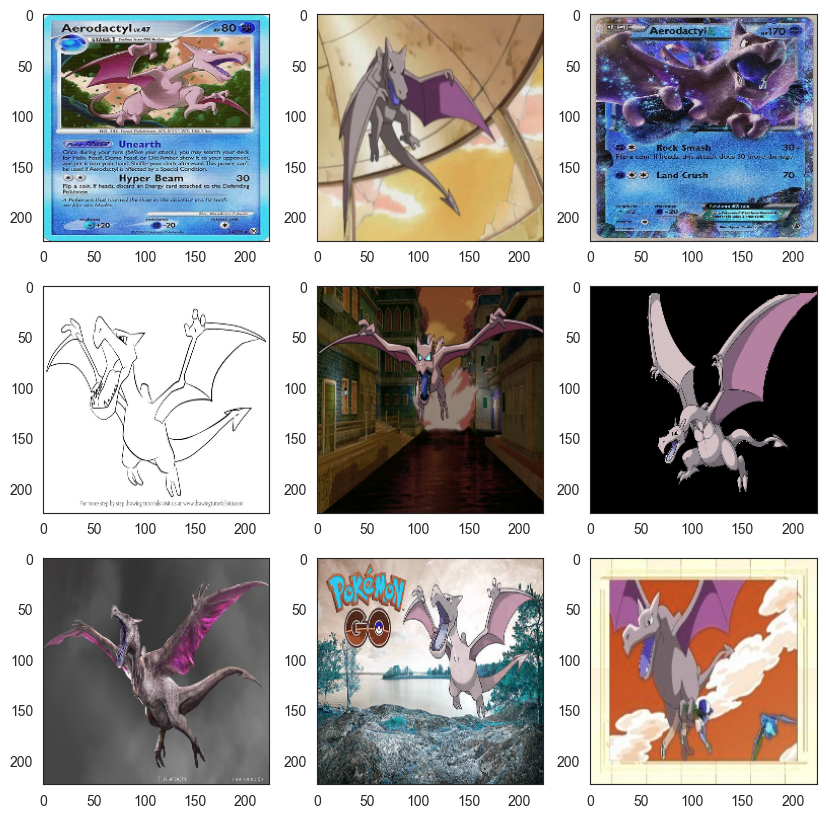

In [5]:
sns.set_style("white")
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(X[i])

plt.show()

In [6]:
y = to_categorical(Y, num_classes = len(classes))

In [7]:
ds = tf.data.Dataset.from_tensor_slices((X, y))

In [8]:
ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(72,), dtype=tf.float64, name=None))>

In [9]:
validation_size = 0.2

validation_size = int(len(ds) * validation_size)

train_ds = ds.skip(validation_size)
validation_ds = ds.take(validation_size)

In [10]:
validation_ds

<_TakeDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(72,), dtype=tf.float64, name=None))>

In [29]:
batch_size = 128
input_shape = (224,224,3)

resize_normalize = lambda x, y: (tf.image.resize(tf.cast(x, tf.float32), input_shape[:2])/255.0, y)

ds_train_batches = train_ds.map(resize_normalize).cache().batch(batch_size).prefetch(buffer_size=10)
ds_validation_batches = validation_ds.map(resize_normalize).cache().batch(batch_size).prefetch(buffer_size=10)

In [30]:
ds_train_batches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 72), dtype=tf.float64, name=None))>

In [31]:
ds_validation_batches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 72), dtype=tf.float64, name=None))>

In [12]:
def create_cnn_model(inShape, convNum, hNum, hAct, outNum, loss):
    """
    :param inShape: kształt wejścia, h*w*c
    :param convNum: lista ilości featerów (kerneli) w warstwach konwolucyjnych
    :param hNum: lista ilości neuronów w poszczególnych warstwach ukrytych
    :param hAct: rodzaj aktywacji w warstwach ukrytych, str
    :param outNum: ilość
    :param loss: funkcja kosztu
    """
    # pusty model
    model = tf.keras.Sequential()
    # warstwa wejściowa
    model.add(layers.InputLayer(input_shape=(inShape)))
    # warstwy konwolucyjne
    for idx, oneConvNum in enumerate(convNum):
        # dodajemy kolejną warstwę konwolucyjną
        # zmienia nam ilość cech(kanałów) na oneConvNum
        model.add(layers.Conv2D(
                                    filters=oneConvNum,
                                    kernel_size=3,
                                    strides=1,
                                    padding="same",
                                    activation="relu"
                                    )
                                )
        # doajemy następującego po convie maxpool'a
        # zmniejsza nam wymiarowość HxW o połowę
        model.add(layers.MaxPool2D(
                                    pool_size=(2, 2),
                                    strides=2,
                                    padding="same"
                                    )
                                )
    # spłaszczamy po konwolucjach, przygotowanie pod relu
    model.add(layers.Flatten())
    # warstwy fully connected
    for idx, oneHidNum in enumerate(hNum):
        # dodajemy warstwę
        model.add(layers.Dense(oneHidNum, activation=hAct))
    # warstwa wyjściowa
    model.add(layers.Dense(outNum))
    # warstwa softmax, dystrybucja prawdopodobieństwa
    model.add(layers.Softmax())
    print(model.summary())

    opt = tf.keras.optimizers.Adam()

    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=["accuracy"]
    )

    return model

In [20]:
modelCNN = create_cnn_model(
    inShape=input_shape,
    convNum=[8,16,24,32,40],
    hNum=[100],
    hAct="relu",
    outNum=72,
    loss=tf.keras.losses.BinaryCrossentropy()
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 224, 224, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 112, 112, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 24)     │         3,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 28, 28, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 32)     │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 14, 14, 40)     │        11,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 7, 7, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │       196,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 72)             │         7,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_3 (Softmax)             │ (None, 72)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 226,748 (885.73 KB)

 Trainable params: 226,748 (885.73 KB)

 Non-trainable params: 0 (0.00 B)

None


In [32]:
history = modelCNN.fit(
    ds_train_batches,
    epochs=60,
    validation_data=ds_validation_batches
)

Epoch 1/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.1381 - loss: 0.0600 - val_accuracy: 0.0000e+00 - val_loss: 0.1613
Epoch 2/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.1741 - loss: 0.0570 - val_accuracy: 0.0000e+00 - val_loss: 0.1653
Epoch 3/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.1923 - loss: 0.0557 - val_accuracy: 0.0011 - val_loss: 0.1679
Epoch 4/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.2119 - loss: 0.0545 - val_accuracy: 0.0011 - val_loss: 0.1716
Epoch 5/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.2352 - loss: 0.0535 - val_accuracy: 0.0022 - val_loss: 0.1740
Epoch 6/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.2486 - loss: 0.0525 - val_accuracy: 0.0022 - val_loss: 0.1768
Epoch 7/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.2677 - loss: 0.0515 - val_accuracy: 0.0033 - val_loss: 0.1794
Epoch 8/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.2838 - loss: 0.0505 - val_accuracy: 0.

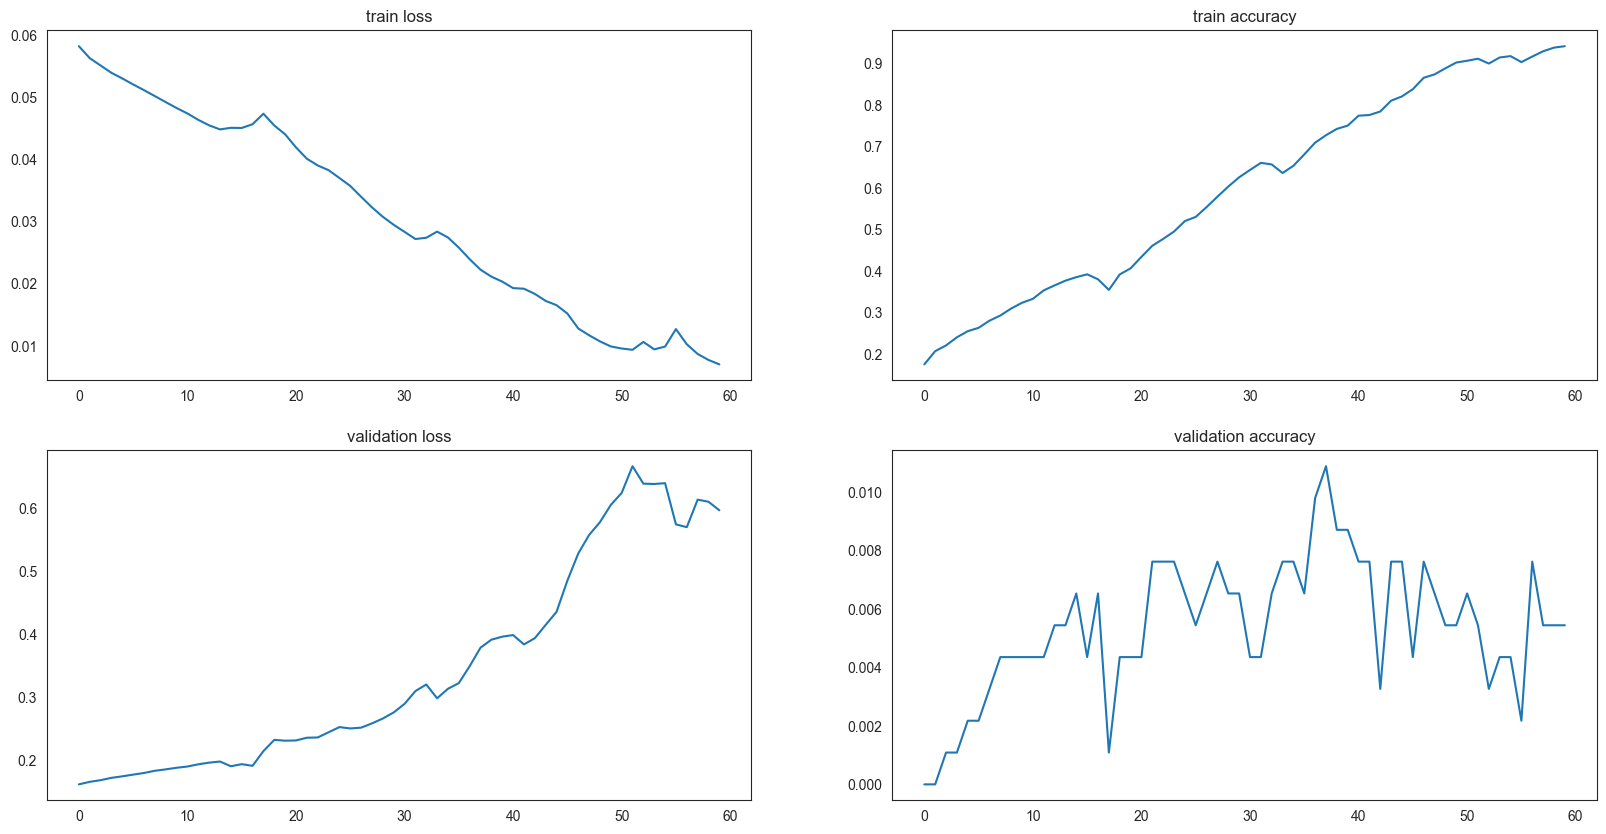

In [33]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history.history["loss"])
ax[0][1].plot(history.history["accuracy"])
ax[1][0].plot(history.history["val_loss"])
ax[1][1].plot(history.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

Text(0.5, 1.0, 'loss')

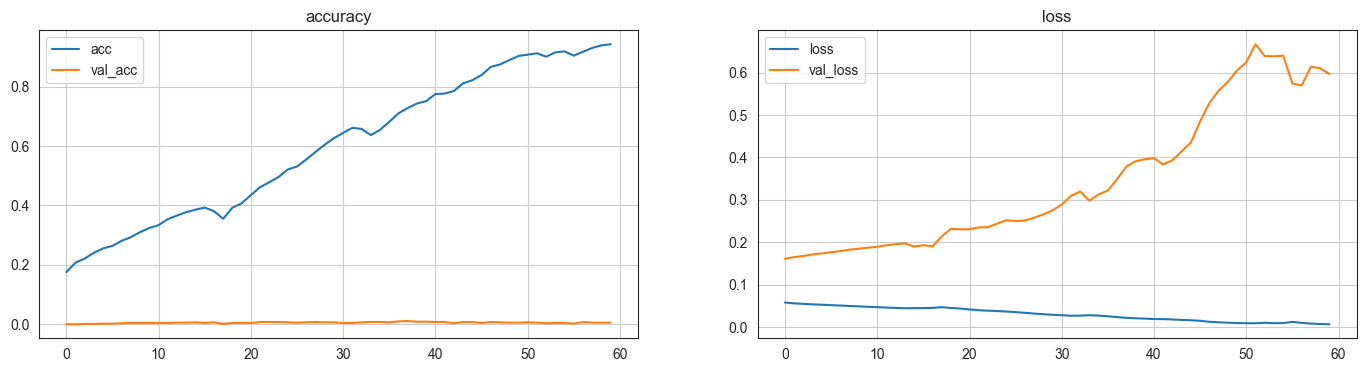

In [34]:
fig = plt.figure(figsize = (17, 4))
    
plt.subplot(121)
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

In [36]:
from sklearn.metrics import accuracy_score, classification_report

predictions = modelCNN.predict(ds_train_batches)
accuracy = accuracy_score(ds_validation_batches, np.argmax(predictions, axis=1))
print(f'Accuracy: {accuracy}')

# Wyświetlenie pełnego raportu klasyfikacji
print(classification_report(ds_validation_batches, np.argmax(predictions, axis=1)))

 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


ValueError: Found input variables with inconsistent numbers of samples: [8, 3678]